In [1]:
# imports
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import math
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
# helper functions
def standard(arr):
    half_max = (np.max(arr) + 1) / 2.0
    arr = (arr - half_max) / half_max
    return arr
def ReLU(x):
    return np.array([i if i > 0 else 0 for i in x])
def ReLU_prime(x):
    return np.array([1 if i > 0 else 0 for i in x])
def tanh_prime(x):
    return 1 - (np.tanh(x) ** 2)
def MSE(obs, pred):
    return np.ndarray.mean((obs - pred) ** 2)
def MSE_prime(obs, pred):
    return 2.0 * (obs - pred) / len(obs)
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)
def one_hot(Y):
    arr_Y = np.zeros([Y.size, 10])
    arr_Y[np.arange(Y.size), Y] = 1;
    return arr_Y


# Xn dimensions: 0 is number of batches, 1 is number of inputs per sample, 2 is batch size
# Yn dimensions: 0 is number of batches, 1 is one-hot encoded values, 2 is batch size
def div_batches(X_data, Y_data, batch_size):
    d_size = len(X_data)
    num_batches = d_size // batch_size
    input_size = X_data.shape[1]
    Xn = np.transpose(X_data.reshape(num_batches, batch_size, input_size), (0,2,1))
    Yn = np.transpose(one_hot(Y_data).reshape(num_batches, batch_size, 10), (0,2,1))
    return Xn, Yn


In [3]:
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

In [4]:
arr_data = np.array(data)
arr_data.shape

(42000, 785)

In [5]:
# prepare data
m, n = arr_data.shape
split = 1000
print("m = ", m, " n = ", n)

data_dev = arr_data[0:split]
data_train = (arr_data[split:m])

Y_train = data_train[:,0] # first column
X_train = data_train[:,1:] # all after first column
print(X_train.shape)
print(Y_train.shape)

Y_dev = data_dev[:,0]
X_dev = data_dev[:,1:]


m =  42000  n =  785
(41000, 784)
(41000,)


In [6]:
Xs, Ys = div_batches(X_train, Y_train, 20)
Xs = standard(Xs)

In [7]:
class Layer:
    
    # n = outputs, neurons
    # m = inputs, weights per neuron
    def __init__(self, m, n, lr):
        stdev = np.sqrt(2.0 / m) # Xavier initialization
        self.weights = np.random.randn(n, m) * stdev
        self.bias = (np.random.rand(n, 1) - 0.5) * 0.01
        self.lr = lr
        
    def forward(self, x):
        self.x = x
        self.z = self.weights @ self.x + self.bias
        self.a = np.tanh(self.z)
        return self.a
    
    def backward(self, dout):
        self.dz = dout * tanh_prime(self.z)
        self.dw = self.dz @ self.x.T
        self.db = np.mean(self.dz, axis=1).reshape(len(self.bias), 1)
        self.dx = self.weights.T @ self.dz  
        return self.dx

    def update(self):
        self.weights = self.weights - self.lr * self.dw 
        self.bias = self.bias - self.lr * self.db 

In [8]:
# np.random.seed(0)

In [9]:
# Initialize network
L1 = Layer(784, 100, 0.01)
L2 = Layer(100, 50, 0.01)
L3 = Layer(50, 10, 0.01)
losses = []
epochs = 3

In [10]:
# gradient descent
for e in range(epochs):
    for x, y in zip(Xs, Ys):
        
        a1 = L1.forward(x)
        a2 = L2.forward(a1)
        a3 = L3.forward(a2)

        smax = softmax(a3)
        loss = MSE(smax, y)
        losses.append(loss)
        dOut = MSE_prime(smax, y)

        dx3 = L3.backward(dOut)
        dx2 = L2.backward(dx3)
        L1.backward(dx2)

        L1.update()
        L2.update()
        L3.update()

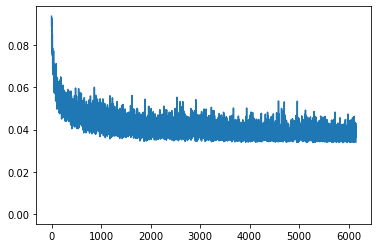

In [11]:
plt.plot(losses)
plt.plot(0)
plt.show()

In [12]:
Xd, _ = div_batches(X_dev, Y_dev, 1) # we do not need to one-hot encode or partition Y_dev
Xd = standard(Xd)

In [13]:
# test for accuracy
correct = 0
total = 1000
for x, y in zip(Xd, Y_dev):
    
    a1 = L1.forward(x)
    a2 = L2.forward(a1)
    a3 = L3.forward(a2)
    
    out = np.argmax(a3)
    
    if out == y:
        correct += 1

print("ACCURACY: ", correct / total)


ACCURACY:  0.944
